In [1]:
import pandas as pd
import numpy as np

cols= ['Q{}'.format(idx) for idx in range(1,11)]
data= pd.read_csv('ouirt.dat', sep= ' ', names= cols)
data.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
NaN,0,1,1,1,1,1,1,1,1,0
NaN,0,1,0,0,1,0,1,0,0,0


In [2]:
data= pd.DataFrame(data.values, columns=cols)
data.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*  Truncating Question items to 3

In [3]:
rel_items = cols[:3]#Q1,Q2,Q3
df = data[rel_items]
df.head(3)

,Q1,Q2,Q3
0,0,1,1
1,0,1,0
2,0,0,0


In [4]:
df_cols = ['user','questions', 'response']#final dataframe cols

In [5]:
from collections import defaultdict
di = defaultdict(dict)
for idx in rel_items:
    di[idx].update(zip(range(df.shape[0]), df[idx].values))#makes format {'Q1':{user:responses,1:0,2:0,. . .,}}

* Following dataframe contains-- user id, questions id, corresponding response value

In [6]:
df_list= list()
for ques, user_resp in list(zip(di.keys(), di.values())):
    df_list.append({'user':list(user_resp.keys()), 'questions':[ques]*df.shape[0], 'response':list(user_resp.values())})

df1=pd.DataFrame(df_list[0])
df2=pd.DataFrame(df_list[1])
df3=pd.DataFrame(df_list[2])
df_new= pd.concat([df1,df2,df3], ignore_index=True)
df_new = df_new.loc[np.random.randint(0,1499, size=1500)]#shuffling data
df_new

,user,questions,response
731,231,Q2,0
707,207,Q2,0
1188,188,Q3,1
1167,167,Q3,1
255,255,Q1,0
...,...,...,...
1080,80,Q3,0
1365,365,Q3,0
1011,11,Q3,0
987,487,Q2,0


### Defining Keras equivalent model

In [7]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [8]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=0.05)

In [9]:
x_train_user = to_categorical(xtrain['user'], num_classes=500)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
      '\nshape of y_train:',y_train.shape)

shape of x_train_user: (1425, 500) 
shape of x_train_questions: (1425, 3) 
shape of y_train: (1425,)


### 3 PL IRT model
* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* a_j= discrimination parameter of j-th question
* c_j= pseudo guessing parameter of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item.

`P{i=1,j} = Sigmoid[c_j+ a_j(1-c_j)(t_i - b_j)]`

In [10]:
from keras import backend as K
from keras.layers import Lambda

In [11]:
#for the purpose of Lambda layer
def ops_func(x, op='add'):
    if op=='add':
        return K.constant(value=np.array([x[0]])) + x[1]
    if op=='subtract':
        return K.constant(value=np.array([x[0]])) - x[1]
    if op=='multiply':
        return K.constant(value=np.array([x[0]]))* x[1]

In [12]:
user_input_layer = Input(shape=(x_train_user.shape[1],), name= 'user_id')#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],), name='questions/items')#bottom half of input

latent_trait = Dense(1, use_bias=False, name='latent_trait')(user_input_layer)

difficulty_level = Dense(1, use_bias=False, name='difficulty_level')(quest_input_layer)
discrimination_param = Dense(1, use_bias=False, name='disc_param')(quest_input_layer)
guess_param = Dense(1, use_bias=False, name='guessing_param')(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract(name='latent_diff_sub')([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply(name='disc_param_inter.')([latent_difficulty_subtract, 
                                                    discrimination_param])

#guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([-1]))*x)(guess_param)
guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([1])) - x, name='guess_param_inter.')(guess_param)
guess_param_interaction= keras.layers.Multiply(name='disc/guess_param_inter.')([disc_param_interaction, 
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add(name='guess_param_inter/add')([guess_param, guess_param_interaction])


#prediction_output = Dense(1, activation='sigmoid')(guess_param_interaction)
# last layer is dummy. it is not trainable, weight =1, bias = 0
prediction_output = Dense(1, activation='sigmoid',trainable=False,use_bias=False,kernel_initializer=keras.initializers.Ones(), name='prediction_layer')(guess_param_interaction)


model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)
model3.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            500         user_id[0][0]                    
__________________________________________________________________________________________________
difficulty_level (Dense)        (None, 1)            3           questions/items[0][0]            
____________________________________________________________________________________________

In [14]:
history= model3.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 107us/step - loss: 0.8892 - mae: 0.5700 - accuracy: 0.2553 - val_loss: 0.8612 - val_mae: 0.5620 - val_accuracy: 0.2632
Epoch 2/8
1140/1140 [==============================] - 0s 22us/step - loss: 0.8427 - mae: 0.5568 - accuracy: 0.2553 - val_loss: 0.8180 - val_mae: 0.5489 - val_accuracy: 0.2632
Epoch 3/8
1140/1140 [==============================] - 0s 30us/step - loss: 0.8010 - mae: 0.5435 - accuracy: 0.2632 - val_loss: 0.7794 - val_mae: 0.5358 - val_accuracy: 0.2912
Epoch 4/8
1140/1140 [==============================] - 0s 24us/step - loss: 0.7637 - mae: 0.5300 - accuracy: 0.3237 - val_loss: 0.7444 - val_mae: 0.5224 - val_accuracy: 0.3404
Epoch 5/8
1140/1140 [==============================] - 0s 28us/step - loss: 0.7299 - mae: 0.5163 - accuracy: 0.4088 - val_loss: 0.7133 - val_mae: 0.5090 - val_accuracy: 0.4912
Epoch 6/8
1140/1140 [===

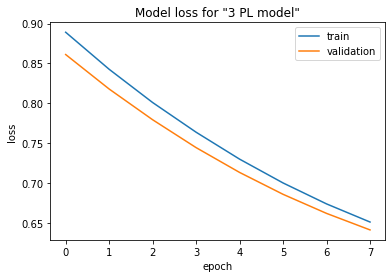

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

#### Obtaining underlying trained 3pl parameters from model

In [17]:
latent_trait_parameters = model3.layers[2].get_weights()#latent trait for 500 users
difficulty_level_parameters= model3.layers[3].get_weights()[0]#difficulty params for 3 Quests/item.
discrimination_parameters= model3.layers[4].get_weights()[0]#dicrimination params for 3 Quests/item.
pseudo_guess_parameters = model3.layers[6].get_weights()[0]#pseudo_guess_params for 3 Quests/item.

In [18]:
difficulty_level_parameters

array([[ 1.2550611 ],
       [-0.37195873],
       [ 1.0615056 ]], dtype=float32)

In [19]:
discrimination_parameters

array([[0.33281645],
       [0.06867713],
       [0.29741564]], dtype=float32)

In [20]:
pseudo_guess_parameters

array([[ 0.732233  ],
       [-0.7838289 ],
       [ 0.65278935]], dtype=float32)

*  histogram for latent traits

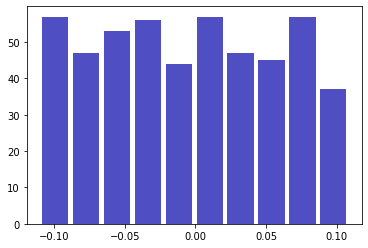

In [21]:
n, bins, patches = plt.hist(x=latent_trait_parameters[0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

* Conditional probablities obtained from R's 3PL

In [22]:
con_prob_r= pd.read_csv('cond_vals.csv')
con_prob_r

,Unnamed: 0,V1,V2,V3
0,1,0.0801,0.1909,0.2382
1,2,0.0801,0.1909,0.2382
2,3,0.0801,0.1909,0.2382
3,4,0.0801,0.1909,0.2382
4,5,0.2688,0.1944,0.2392
5,6,0.3867,0.5033,0.5717
6,7,0.3726,0.4059,0.4484
7,8,0.4724,0.9519,0.9851


* Importing Key paramters obtained from R's 3PL model

In [23]:
coeff = pd.read_csv('coeffs.csv')
coeff

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.000515,1.658634,1.384051
1,V2,0.190866,1.360936,12.716492
2,V3,0.238183,1.339720,16.426231


In [24]:
r_params_cols= list(coeff.columns)
r_params_cols#columns from R's dataframe

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

* Normalising Difficulty, Descrimination values from R's dataframe

In [25]:
normalized_diff_r=coeff[r_params_cols[2]]/coeff[r_params_cols[2]].sum()
normalized_diff_r#new difficulty vals from R

0    0.380483
1    0.312192
2    0.307325
Name: Dffclt, dtype: float64

In [26]:
normalized_desc_r=coeff[r_params_cols[-1]]/coeff[r_params_cols[-1]].sum()
normalized_desc_r#new descrimination vals from R

0    0.045339
1    0.416568
2    0.538093
Name: Dscrmn, dtype: float64

### Scatterplots: difficulty vals from keras_3pl vs. R_3pl

In [27]:
d1 = (np.array(range(1, len(rel_items)+1)), difficulty_level_parameters)

d2 = (np.array(range(1, len(rel_items)+1)), normalized_diff_r.values)

data_diff= (d1,d2)

In [28]:
d1

(array([1, 2, 3]), array([[ 1.2550611 ],
        [-0.37195873],
        [ 1.0615056 ]], dtype=float32))

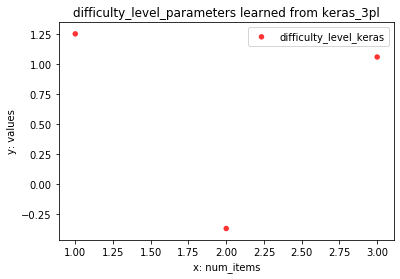

In [29]:
colors = ("red", "blue")
groups = ("difficulty_level_keras", "difficulty_level_R")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d1 
ax.scatter(x, y, alpha=0.8, c=colors[0], edgecolors='none', s=30, label=groups[0])
plt.title('difficulty_level_parameters learned from keras_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=1)
plt.show()

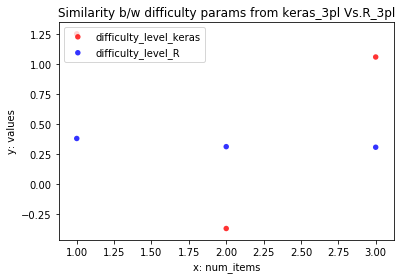

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data_diff, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w difficulty params from keras_3pl Vs.R_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=2)
plt.show()

### Scatterplot: discrimination vals from keras_3pl vs. R_3pl

In [31]:
d1 = (np.array(range(1, len(rel_items)+1)), discrimination_parameters)

d2 = (np.array(range(1, len(rel_items)+1)), normalized_desc_r.values)

data_desc= (d1,d2)

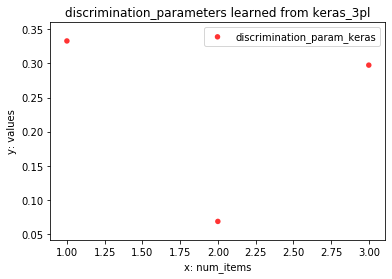

In [32]:
colors = ("red", "blue")
groups = ("discrimination_param_keras", "discrimination_param_R")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d1
ax.scatter(x, y, alpha=0.8, c=colors[0], edgecolors='none', s=30, label=groups[0])
plt.title('discrimination_parameters learned from keras_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=1)
plt.show()

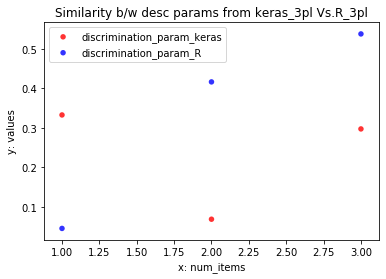

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data_desc, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w desc params from keras_3pl Vs.R_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=2)
plt.show()

### Scatterplot: guessing values from keras_3pl vs. R_3pl

In [34]:
d1 = (np.array(range(1, len(rel_items)+1)), pseudo_guess_parameters)

d2 = (np.array(range(1, len(rel_items)+1)), coeff[r_params_cols[1]].values)

data_guess= (d1,d2)

coeff[r_params_cols[1]]#guessing params from R

0    0.000515
1    0.190866
2    0.238183
Name: Gussng, dtype: float64

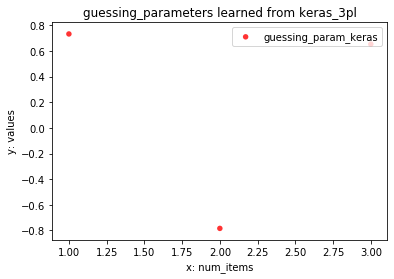

In [35]:
colors = ("red", "blue")
groups = ("guessing_param_keras", "guessing_param_R")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d1
ax.scatter(x, y, alpha=0.8, c=colors[0], edgecolors='none', s=30, label=groups[0])
plt.title('guessing_parameters learned from keras_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=1)
plt.show()

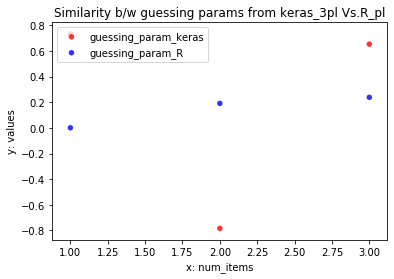

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data_guess, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w guessing params from keras_3pl Vs.R_pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=2)
plt.show()

### Item Characteristic curves for item1 from keras_3pl vs. R_3pl

In [37]:
coeff

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.000515,1.658634,1.384051
1,V2,0.190866,1.360936,12.716492
2,V3,0.238183,1.339720,16.426231


In [38]:
r_params_cols

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

* plotting function

In [39]:
x = np.linspace(-4,4, num=500)
def logit_func(x):#c:guess, a:descrimination, b:difficulty
    val = list()
    val.append(c+ (1-c)*(np.exp(a*(x-b))/(1+np.exp(a*(x-b)))))
    return val

* calculating plots for R's item 1 & keras's item 1

In [40]:
c= coeff[r_params_cols[1]].iloc[0]#values of item 1 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[0]
b= coeff[r_params_cols[2]].iloc[0]
vals_r= logit_func(x)#logits for R's dataframe

In [41]:
c= pseudo_guess_parameters[0]#values for item 1 from keras 3pl params
a= discrimination_parameters[0]
b= difficulty_level_parameters[0]
vals_keras= logit_func(x)#logits for R's dataframe

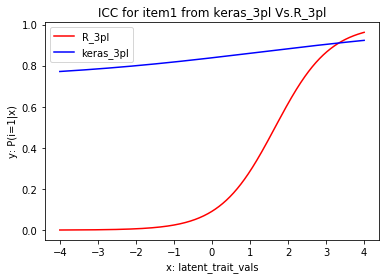

In [42]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item1 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 2 & keras's item 2

In [43]:
c= coeff[r_params_cols[1]].iloc[1]#values of item 2 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[1]
b= coeff[r_params_cols[2]].iloc[1]
vals_r= logit_func(x)#logits for R's dataframe

In [44]:
c= pseudo_guess_parameters[1]#values for item 2 from keras 3pl params
a= discrimination_parameters[1]
b= difficulty_level_parameters[1]
vals_keras= logit_func(x)#logits for R's dataframe

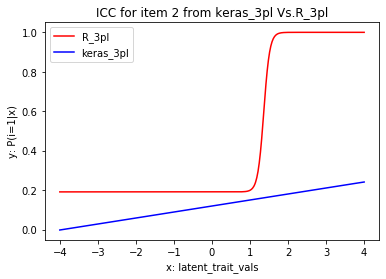

In [45]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 2 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 3

In [46]:
c= coeff[r_params_cols[1]].iloc[2]#values of item 3 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[2]
b= coeff[r_params_cols[2]].iloc[2]
vals_r= logit_func(x)#logits for R's dataframe

In [47]:
c= pseudo_guess_parameters[2]#values for item 3 from keras 3pl params
a= discrimination_parameters[2]
b= difficulty_level_parameters[2]
vals_keras= logit_func(x)#logits for R's dataframe

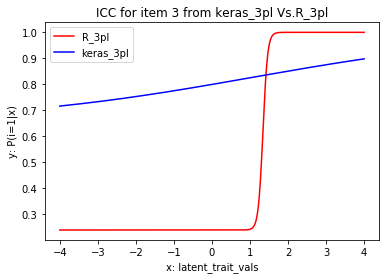

In [48]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 3 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()